### Project CLEAN: Communication Link Estimation & Adaptive Noise-reduction

**Objective:** Use LMS and RLS adaptive filters to recover a clean signal from noise.

This notebook can leverages example of **PySDR** available at :
https://github.com/777arc/PySDR/tree/ba4f470767bbd5b460217ec2f78ade82845c15e8/figure-generating-scripts

**Tasks:**
- Generate noisy signal : https://pysdr.org/content/noise.html
- Apply LMS and RLS filters : see /src
- Compare performance and convergence

## 1. Import Libraries

In [ ]:
#!python --version
#
# 

















!pip install -r ../requirements.txt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Custom utils
import sys
sys.path.append('../src')
from utils import *
from filters import *

### Last Mean Square (LMS) - Filter
![Block diagram LMS (Last Mean Square) - Filter](picture/block_diagram_lms_filter.png)

# LMS Algorithmus Formula

Error Signal:
$$
e[n] = d[n] - y[n]
$$

Filter Output:
$$
y[n] = \sum_{i=0}^{N-1} w_i[n] \cdot x_i[n - i]
$$

Weight Coefficient Update:
$$
w_{i}[n+1] = w_{i}[n] + 2 \cdot \mu \cdot e[n] \cdot x[n - i]
$$

Symbol - Description:
- \( x[n] \): Input (Noisy) Signal 
- \( d[n] \): Reference (Clear) Signal 
- \( \mu \): Lerning Rate


#### LMS Test

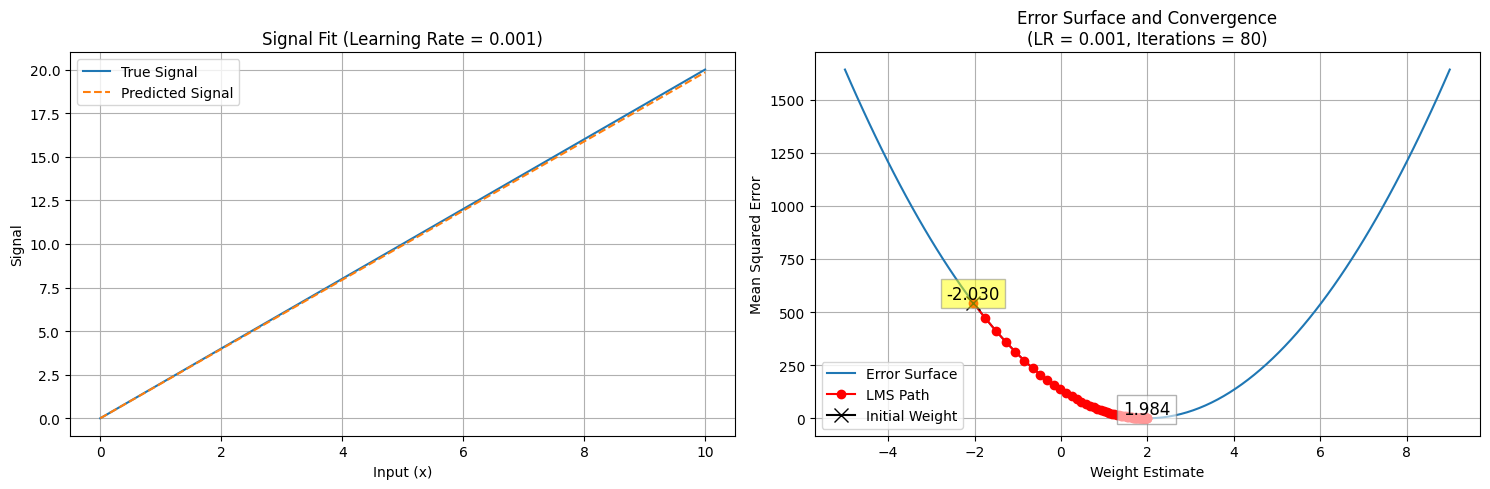

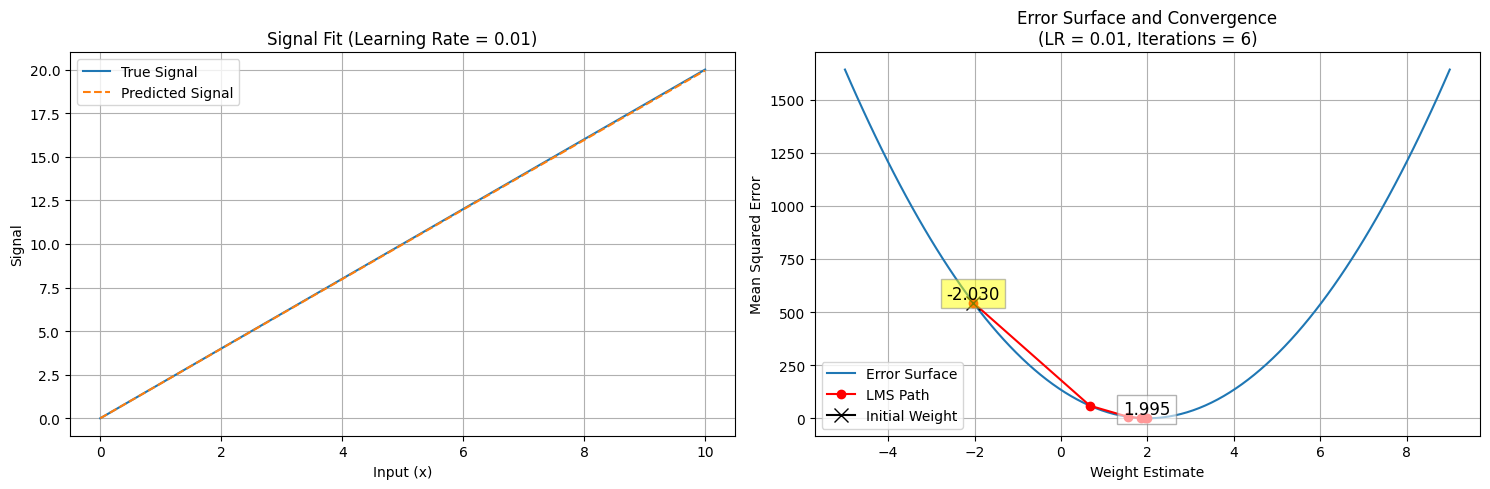

C:\Users\cyril\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\cyril\AppData\Local\Temp\ipykernel_18936\2957939351.py:36: RuntimeWarning: overflow encountered in square
  mse = np.mean(pred_err ** 2)
C:\Users\cyril\AppData\Local\Temp\ipykernel_18936\2957939351.py:34: RuntimeWarning: invalid value encountered in multiply
  prediction = current_wt * values


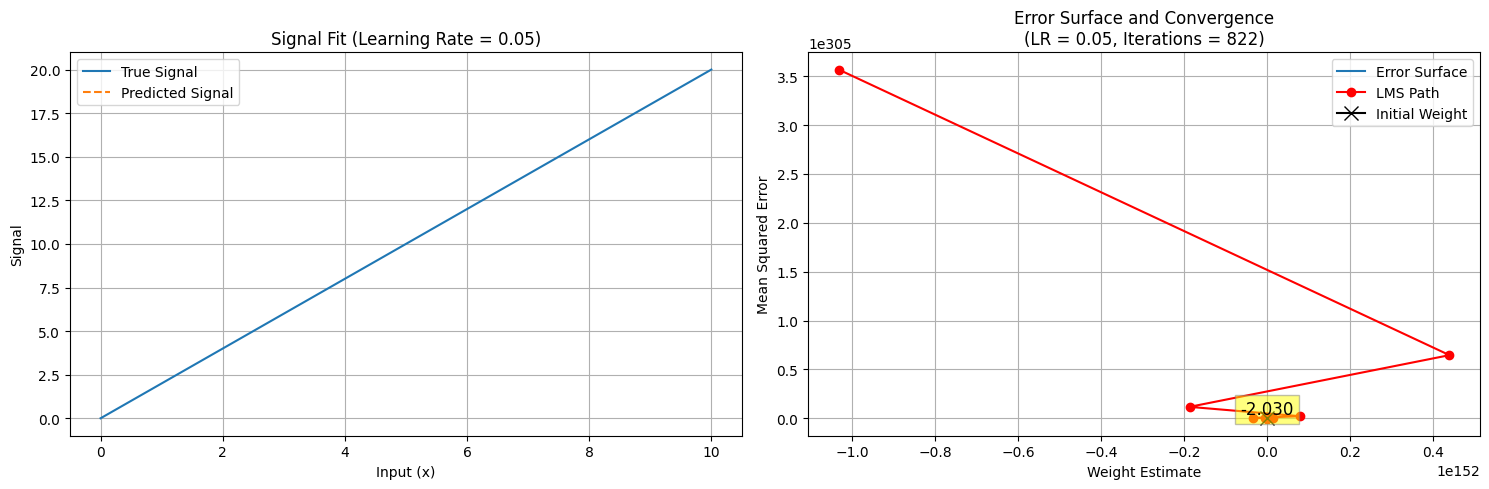

In [ ]:

# Generate Testsignal with defined weight
n_values = 100
values = np.linspace(0, 10, n_values)  # generate test values
fixed_wt = 2  # true weight
signal = fixed_wt * values

# Calculate estimated mean squared errors for error surface
wt_est = np.linspace(-5, 9, n_values)
err_history = []
for wt in wt_est:
    prediction = wt * values
    err = signal - prediction
    mean_sq_error = np.mean(err ** 2)
    err_history.append(mean_sq_error)

# learning rates
learning_rates = [0.001, 0.01, 0.05]
err_tolerance = 0.01 
max_iter = 2000 # maximum repetition (error handling)

# pick one random init weight
init_wt = np.random.choice(wt_est, 1)[0]

# repetition for each learning rate
for lr in learning_rates:
    wt_record = []
    mse_record = []

    curr_error = 1
    numIter = 0
    current_wt = init_wt

    while curr_error > err_tolerance and numIter < max_iter:
        prediction = current_wt * values
        pred_err = signal - prediction
        mse = np.mean(pred_err ** 2)

        wt_record.append(current_wt)
        mse_record.append(mse)

        grad = -2 * np.mean(pred_err * values)
        new_wt = current_wt - lr * grad

        current_wt = new_wt

        curr_error = mse
        numIter += 1

    # new figure for each learning rate
    plt.figure(figsize=(15, 5))

    # first plot - signal compare 
    plt.subplot(1, 2, 1)
    plt.plot(values, signal, label="True Signal")
    plt.plot(values, current_wt * values, linestyle='--', label="Predicted Signal")
    plt.xlabel("Input (x)")
    plt.ylabel("Signal")
    plt.title(f"Signal Fit (Learning Rate = {lr})")
    plt.legend()
    plt.grid()

    # second plot - convergence
    plt.subplot(1, 2, 2)
    plt.plot(wt_est, err_history, label="Error Surface")
    plt.plot(wt_record, mse_record, 'ro-', label="LMS Path")

    # mark initial weight
    plt.plot(
        wt_record[0],
        mse_record[0],
        marker='x',
        markersize=10,
        color='black',
        label='Initial Weight'
    )
    plt.text(
        wt_record[0],
        mse_record[0],
        f'{wt_record[0]:.3f}',
        fontsize=12,
        bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='gray'),
        verticalalignment='bottom',
        horizontalalignment='center'
    )

    # mark final weight (found by lms)
    plt.text(
        wt_record[-1],
        mse_record[-1],
        f'{current_wt:.3f}',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'),
        verticalalignment='bottom',
        horizontalalignment='center'
    )

    plt.xlabel("Weight Estimate")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Error Surface and Convergence\n(LR = {lr}, Iterations = {numIter})")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


## 2. Generate Noisy Signal
- Clean reference: sine wave
- Add Gaussian noise using PySDR example

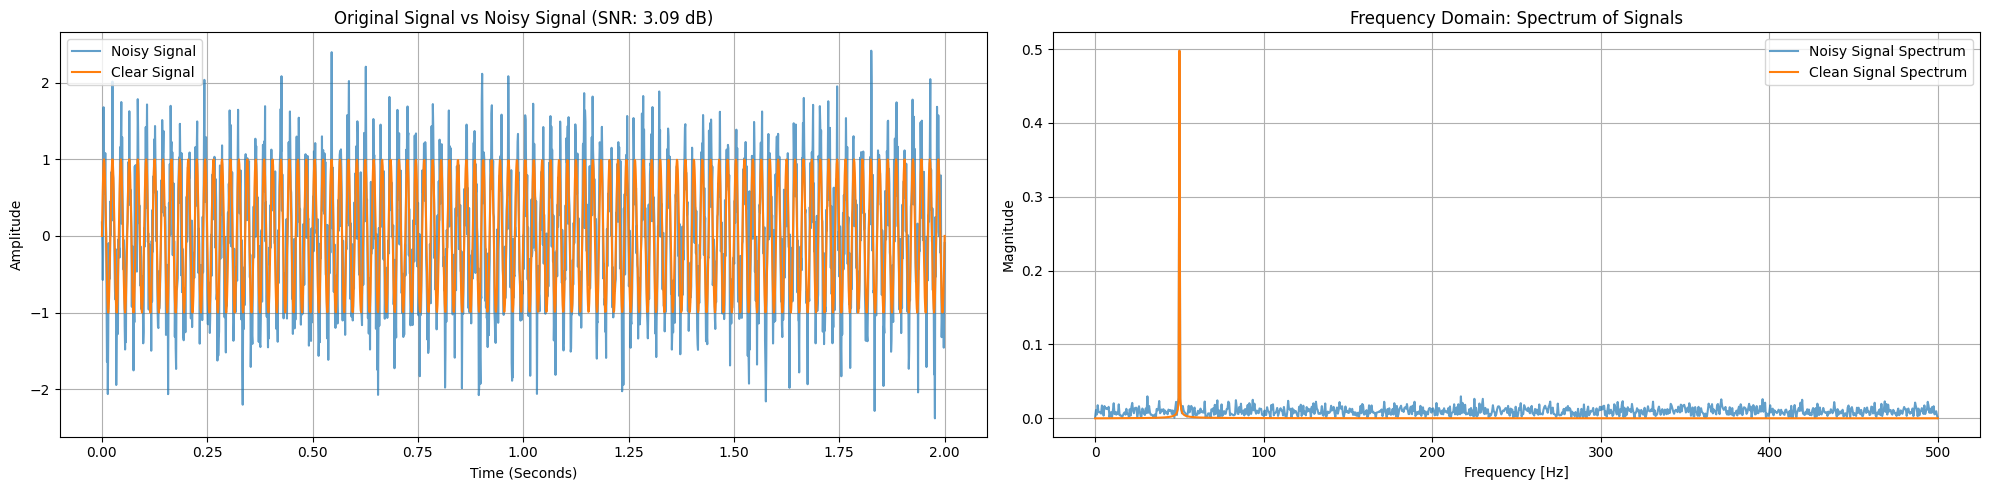

In [ ]:

def calc_snr(signal, noisy_signal):
    """calculate signal to noise ratio"""
    signal_power = np.mean(signal**2)  # power of clear signal
    noise_power = np.mean((noisy_signal - signal)**2)  # power of noise
    calc_snr_db = 10 * np.log10(signal_power / noise_power)  # calculated snr in db
    return calc_snr_db


# Parameter
Fs = 1000  # Sampling rate
T = 2  # Duration
freq = 5  # Frequency
time = np.linspace(0, T, T * Fs)

# Generate Sine-Wave (Sinus)
signal = np.sin(2 * np.pi * freq * time)

# generate dc signal
#signal = np.ones(len(time)) * 2


# simulate AWG-channel - add noise to channel
snr_db = 3  # SNR in dB
noisy_signal = add_awgn_noise(signal, snr_db)

# calc current signal to noise ratio (snr)
calculated_snr = calc_snr(signal, noisy_signal)

# Compute FFT for spectrum
n = len(signal)
freqs = np.fft.rfftfreq(n, d=1/Fs)
spectrum_clean = np.abs(np.fft.rfft(signal)) / n
spectrum_noisy = np.abs(np.fft.rfft(noisy_signal)) / n


plt.figure(figsize=(20, 5))
# plot clear and noisy signal
plt.subplot(1, 2, 1)
plt.plot(time, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(time, signal, label='Clear Signal')
plt.title(f'Original Signal vs Noisy Signal (SNR: {calculated_snr:.2f} dB)')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()


# Plot spectrum
plt.subplot(1, 2, 2)
plt.plot(freqs, spectrum_noisy, label='Noisy Signal Spectrum', alpha=0.7)
plt.plot(freqs, spectrum_clean, label='Clean Signal Spectrum')
plt.title('Frequency Domain: Spectrum of Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



## 3. LMS Adaptive Filtering

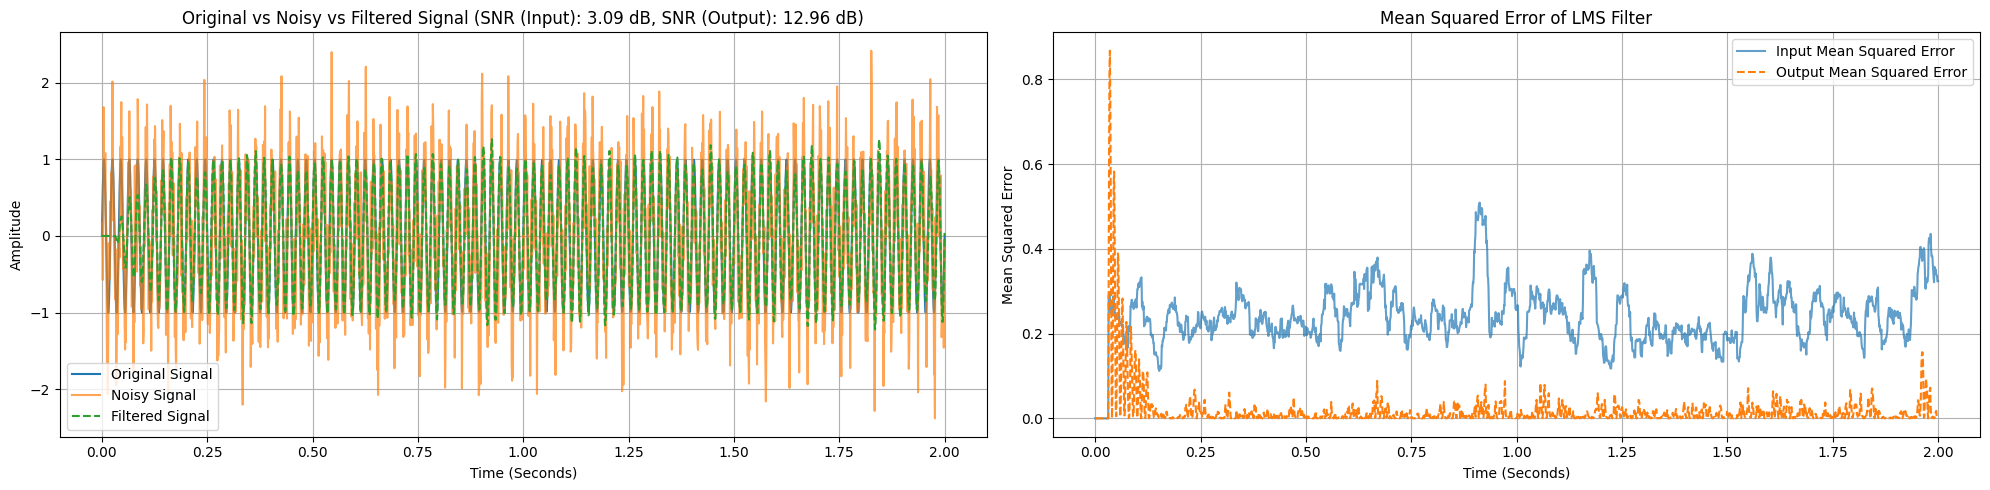

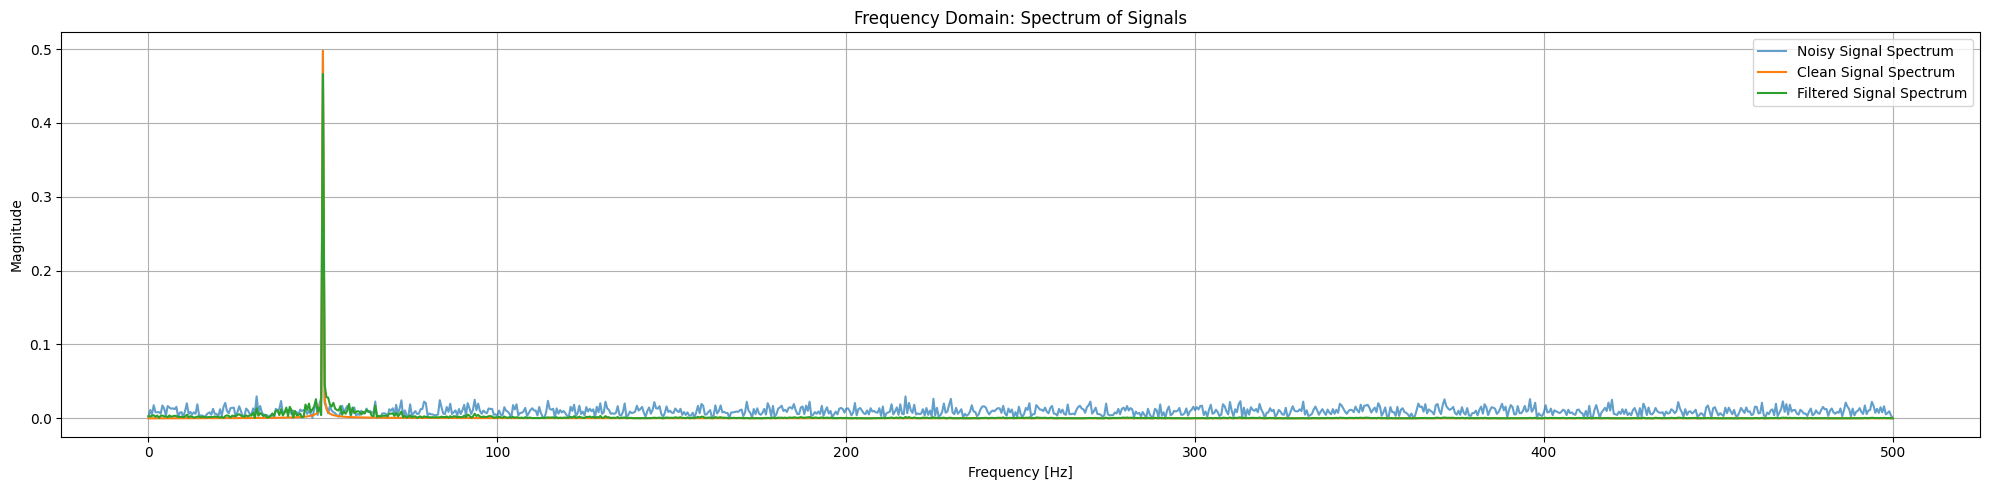

In [161]:

# lms - filter function
def lms_filter(noisy_signal, desired_signal, learn_rate=0.01, num_tabs=32):
    """
    Apply LMS filter to noisy signal and return filtered signal, 
    mean squared error input/output, and weight history.
    """
    n = len(noisy_signal)
    weights = np.zeros(num_tabs)  # Initialize with zero
    filter_out = np.zeros(n)  # array for filtered output (y(n))
    mse_in = np.zeros(n)  # array for input mean squared error
    mse_out = np.zeros(n)  # array for output mean squared error
    
    for i in range(num_tabs, n):
        x = noisy_signal[i - num_tabs: i][::-1]  # input window 
        filter_out[i] = np.dot(weights, x)  # filter output (matrix multiply)
        error_out = desired_signal[i] - filter_out[i]  # calc error (d - y) => referenz signal - filtered signal
        error_in = desired_signal[i - num_tabs: i] - noisy_signal[i - num_tabs: i]  # error reference / noisy signal
        mse_in[i] = np.mean(error_in**2)  # Input Mean Squared Error
        mse_out[i] = error_out**2  # Output Mean Squared Error
        grad = -2 * learn_rate * error_out * x  # gradient 
        weights = weights - grad  # update weight

    return filter_out, mse_in, mse_out



# use lms - filter
learn_rate = 0.001
num_tabs = 32
filter_out, mse_in, mse_out = lms_filter(noisy_signal, signal, learn_rate, num_tabs)

# calculate signal to noise ratio
snr_input = calc_snr(signal, noisy_signal)
snr_output = calc_snr(signal, filter_out)

# Compute FFT for spectrum
n = len(signal)
freqs = np.fft.rfftfreq(n, d=1/Fs)
spectrum_clean = np.abs(np.fft.rfft(signal)) / n
spectrum_noisy = np.abs(np.fft.rfft(noisy_signal)) / n
spectrum_filtered = np.abs(np.fft.rfft(filter_out)) / n


plt.figure(figsize=(20, 5))

# Subplot 1: Original vs Noisy vs Filtered Signal
plt.subplot(1, 2, 1)
plt.plot(time, signal, label='Original Signal')
plt.plot(time, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(time, filter_out, label='Filtered Signal', linestyle='--')
plt.title(f'Original vs Noisy vs Filtered Signal (SNR (Input): {snr_input:.2f} dB, SNR (Output): {snr_output:.2f} dB)')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Subplot 2: Mean Squared Error
plt.subplot(1, 2, 2)
plt.plot(time, mse_in, label='Input Mean Squared Error', alpha=0.7)
plt.plot(time, mse_out, label='Output Mean Squared Error', linestyle='--')
plt.title('Mean Squared Error of LMS Filter')
plt.xlabel('Time (Seconds)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



plt.figure(figsize=(20, 5))
# plot spectrum
plt.plot(freqs, spectrum_noisy, label='Noisy Signal Spectrum', alpha=0.7)
plt.plot(freqs, spectrum_clean, label='Clean Signal Spectrum')
plt.plot(freqs, spectrum_filtered, label='Filtered Signal Spectrum')
plt.title('Frequency Domain: Spectrum of Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()



## 4. RLS Adaptive Filtering



**Error-Signal:**
$$
e[n] = d[n] - \mathbf{w}^T[n] \cdot \mathbf{u}[n]
$$

**Gain-Vektor:**
$$
\mathbf{g}[n] = \frac{\mathbf{P}[n-1] \cdot \mathbf{u}[n]}{\lambda + \mathbf{u}^T[n] \cdot \mathbf{P}[n-1] \cdot \mathbf{u}[n]}
$$

**Weight-Vector Update:**
$$
\mathbf{w}[n] = \mathbf{w}[n-1] + e[n] \cdot \mathbf{g}[n]
$$

**Inverse-Korrelationsmatrix Update:**
$$
\mathbf{P}[n] = \lambda^{-1}\Bigl[ \mathbf{P}[n-1] - \mathbf{g}[n] \cdot \mathbf{u}^T[n] \cdot \mathbf{P}[n-1] \Bigr]
$$

---

**Symbols:**
- \(\mathbf{u}[n]\): Input \(N\)
- \(\mathbf{w}[n]\): Weights \(N\)
- \(\lambda\): Forgetting Factor (z.B. 0.99–1)
- \(\mathbf{P}[n]\): Inverse Autokorrelationsmatrix
- \(e[n]\): Error
- \(d[n]\): Reference


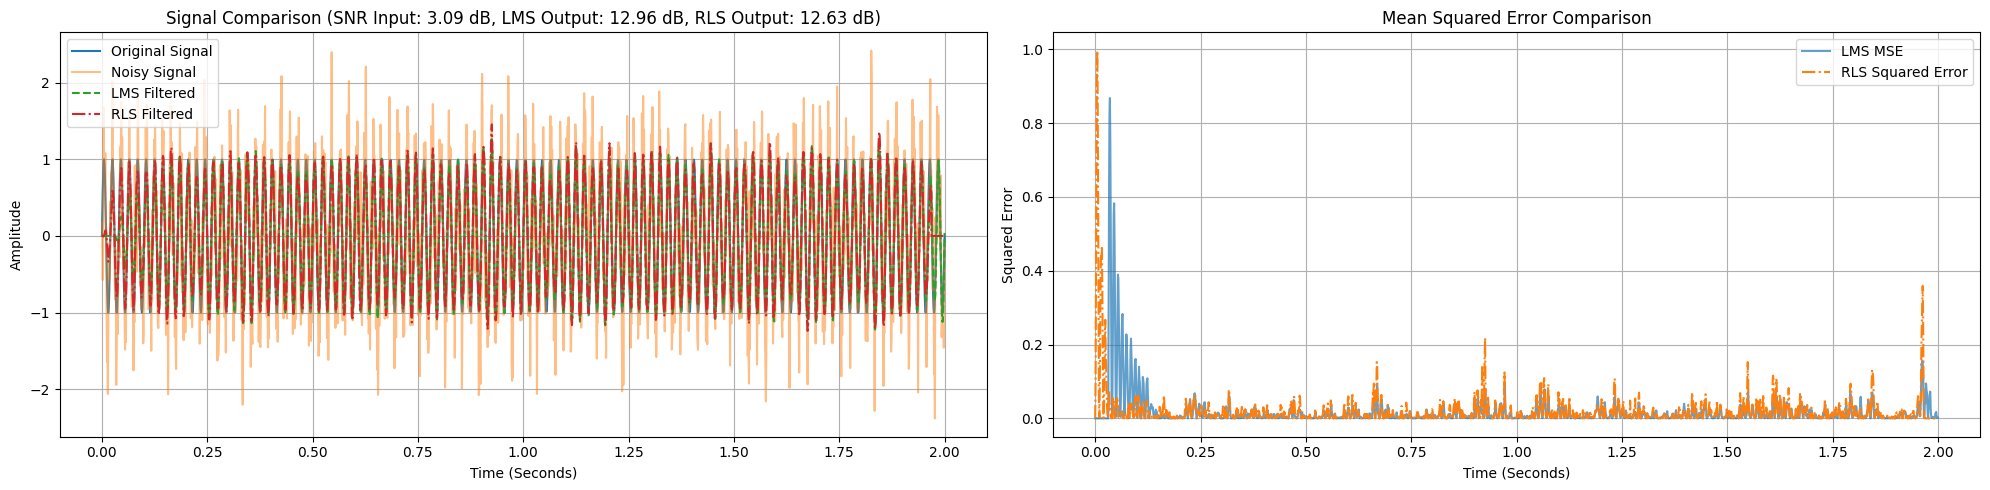

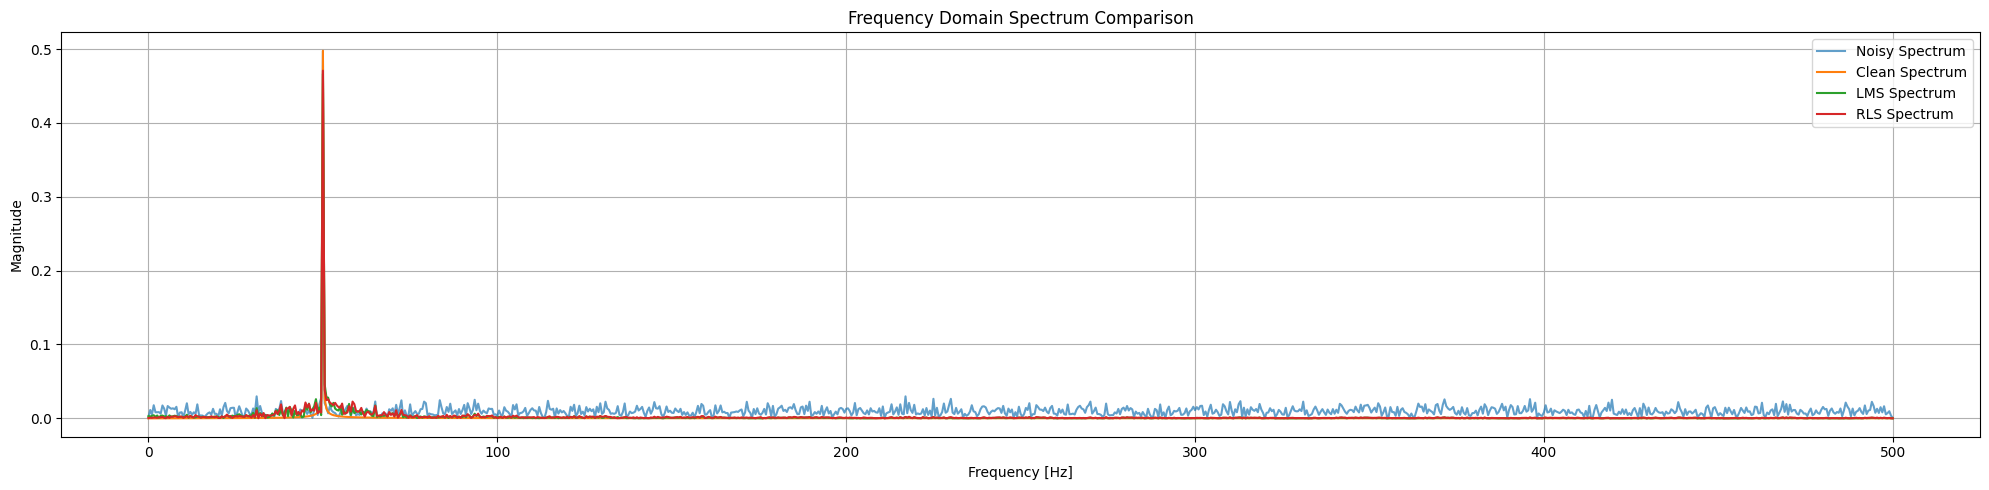

In [172]:

def rls(x, d, N=4, lmbd=0.999, delta=0.01):
    nIters = min(len(x), len(d)) - N
    lmbd_inv = 1 / lmbd
    u = np.zeros(N)
    w = np.zeros(N)
    P = np.eye(N) * delta
    e = np.zeros(len(x))
    y_hat = np.zeros(len(x))
    
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        y_hat[n] = np.dot(u, w)
        e_n = d[n] - y_hat[n]
        r = np.dot(P, u)
        g = r / (lmbd + np.dot(u, r))
        w = w + e_n * g
        P = lmbd_inv * (P - np.outer(g, np.dot(u, P)))
        e[n] = e_n
        
    return y_hat, e


# RLS Parameter
num_tabs_rls = 32
lambda_rls = 0.98
delta_rls = 0.01

# Filter anwenden
filter_out_rls, error_rls = rls(noisy_signal, signal, N=num_tabs_rls, lmbd=lambda_rls, delta=delta_rls)

# SNR berechnen
snr_output_rls = calc_snr(signal, filter_out_rls)


plt.figure(figsize=(20, 5))

# Subplot 1: Zeitbereich
plt.subplot(1, 2, 1)
plt.plot(time, signal, label='Original Signal')
plt.plot(time, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(time, filter_out, label='LMS Filtered', linestyle='--')
plt.plot(time, filter_out_rls, label='RLS Filtered', linestyle='-.')
plt.title(f"Signal Comparison (SNR Input: {snr_input:.2f} dB, LMS Output: {snr_output:.2f} dB, RLS Output: {snr_output_rls:.2f} dB)")
plt.xlabel("Time (Seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

# Subplot 2: Mean Squared Error (nur LMS, RLS Fehlerquadrate)
plt.subplot(1, 2, 2)
plt.plot(time, mse_out, label='LMS MSE', alpha=0.7)
plt.plot(time, error_rls**2, label='RLS Squared Error', linestyle='-.')
plt.title("Mean Squared Error Comparison")
plt.xlabel("Time (Seconds)")
plt.ylabel("Squared Error")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



spectrum_filtered_rls = np.abs(np.fft.rfft(filter_out_rls)) / n

plt.figure(figsize=(20, 5))
plt.plot(freqs, spectrum_noisy, label='Noisy Spectrum', alpha=0.7)
plt.plot(freqs, spectrum_clean, label='Clean Spectrum')
plt.plot(freqs, spectrum_filtered, label='LMS Spectrum')
plt.plot(freqs, spectrum_filtered_rls, label='RLS Spectrum')
plt.title('Frequency Domain Spectrum Comparison')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# TODO: Benchmark the approach

## 5. Comparison and Reflection
- Which filter converged faster?        RLS
- Final noise reduction difference?     